In [13]:
# ========== 纯 HTML 按钮版损失绘图工具 ==========
import json
import matplotlib.pyplot as plt
from pathlib import Path
from IPython.display import display, clear_output
import warnings
from datetime import datetime

%matplotlib inline
warnings.filterwarnings("ignore")

# 配置
json_file = Path("/data1/lxy_log/workspace/ms/UnLanedet/output/llanet/mobilenetv4_small_gsafpn_openlane/detailed_metrics.json")
UPDATE_INTERVAL = 20  # 每20次迭代更新一次

# 安全加载函数
def load_metrics_safe(json_path):
    metrics = []
    if not json_path.exists():
        return metrics
    try:
        with open(json_path, "r") as f:
            for line in f:
                line = line.strip()
                if not line:
                    continue
                try:
                    metrics.append(json.loads(line))
                except json.JSONDecodeError:
                    continue
    except Exception as e:
        print(f"读取文件失败: {e}")
    return metrics

# 提取数据函数
def extract_data(metrics):
    if not metrics:
        return [], [], [], [], [], [], [], [], [], [], []
    iters = [m.get('iteration', 0) for m in metrics]
    loss_start_y = [m.get('loss_start_y', 0) for m in metrics]
    loss_start_x = [m.get('loss_start_x', 0) for m in metrics]
    loss_theta = [m.get('loss_theta', 0) for m in metrics]
    loss_length = [m.get('loss_length', 0) for m in metrics]
    reg_xytl_loss = [m.get('reg_xytl_loss', 0) for m in metrics]
    cls_loss = [m.get('cls_loss', 0) for m in metrics]
    iou_loss = [m.get('iou_loss', 0) for m in metrics]
    loss_category = [m.get('loss_category', 0) for m in metrics]
    loss_attribute = [m.get('loss_attribute', 0) for m in metrics] 
    seg_loss = [m.get('seg_loss', 0) for m in metrics]
    return iters, loss_start_y, loss_start_x, loss_theta, loss_length, reg_xytl_loss, cls_loss, iou_loss, loss_category, loss_attribute, seg_loss

# 全局状态
last_displayed_iter = -1

In [14]:
# ========== 绘图函数（第 2 个 cell，索引 1）==========
def plot_all_losses():
    global last_displayed_iter
    clear_output(wait=True)

    metrics = load_metrics_safe(json_file)
    if not metrics:
        print("❌ 无数据可绘制，请检查 detailed_metrics.json 文件")
        return

    (
        iters,
        loss_start_y,
        loss_start_x,
        loss_theta,
        loss_length,
        reg_xytl_loss,
        cls_loss,
        iou_loss,
        loss_category,
        loss_attribute,
        seg_loss,
    ) = extract_data(metrics)

    if not iters:
        print("❌ 数据中无有效迭代信息")
        return

    current_iter = iters[-1]

    # 检查是否需要更新
    if (
        current_iter // UPDATE_INTERVAL <= last_displayed_iter // UPDATE_INTERVAL
        and last_displayed_iter != -1
    ):
        print(
            f"📊 当前迭代 {current_iter}，上次显示 {last_displayed_iter}，未达更新间隔（{UPDATE_INTERVAL}次迭代）"
        )
        print("💡 点击下方按钮强制刷新")
        return

    print(f"📈 更新损失图表 - 迭代 {current_iter} (共 {len(metrics)} 条记录)")

    # ===== 图1: XYTL 分项损失 =====
    fig1, axes1 = plt.subplots(2, 3, figsize=(18, 10))
    fig1.suptitle("XYTL Component Losses", fontsize=16)
    colors = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b"]
    axes1[0, 0].plot(iters, loss_start_y, color=colors[0], linewidth=2, label="Start Y")
    axes1[0, 0].set_title("Start Y Loss")
    axes1[0, 0].grid(True)
    axes1[0, 0].legend()
    axes1[0, 1].plot(iters, loss_start_x, color=colors[1], linewidth=2, label="Start X")
    axes1[0, 1].set_title("Start X Loss")
    axes1[0, 1].grid(True)
    axes1[0, 1].legend()
    axes1[1, 0].plot(iters, loss_theta, color=colors[2], linewidth=2, label="Theta")
    axes1[1, 0].set_title("Theta Loss")
    axes1[1, 0].grid(True)
    axes1[1, 0].legend()
    axes1[1, 1].plot(iters, loss_length, color=colors[3], linewidth=2, label="Length")
    axes1[1, 1].set_title("Length Loss")
    axes1[1, 1].grid(True)
    axes1[1, 1].legend()
    axes1[0, 2].plot(
        iters, reg_xytl_loss, color=colors[4], linewidth=2, label="Reg XYTL"
    )
    axes1[0, 2].set_title("Regression XYTL Loss")
    axes1[0, 2].grid(True)
    axes1[0, 2].legend()
    axes1[1, 2].plot(iters, cls_loss, color=colors[5], linewidth=2, label="Cls Loss")
    axes1[1, 2].set_title("Cls Loss")
    axes1[1, 2].grid(True)
    axes1[1, 2].legend()
    plt.tight_layout()
    plt.show()

    # ===== 图2: 主要损失（含权重）=====
    fig2, ax2 = plt.subplots(figsize=(12, 6))
    fig2.suptitle("Main Losses (with weights)", fontsize=14)
    main_losses = [
        "reg_xytl_loss",
        "cls_loss",
        "iou_loss",
        "loss_category",
        "loss_attribute",
        "seg_loss",
    ]
    colors_main = ["#1f77b4", "#ff7f0e", "#2ca02c", "#d62728", "#9467bd", "#8c564b"]
    weights = {
        "reg_xytl_loss": 0.05,
        "cls_loss": 4.0,
        "iou_loss": 2.0,
        "loss_category": 2.0,
        "loss_attribute": 0.5,
        "seg_loss": 1.0,
    }
    for i, key in enumerate(main_losses):
        if key == "reg_xytl_loss":
            ax2.plot(
                iters,
                reg_xytl_loss,
                color=colors_main[i],
                linewidth=2,
                label=f"{key} (w={weights[key]})",
            )
        elif key == "cls_loss":
            ax2.plot(
                iters,
                cls_loss,
                color=colors_main[i],
                linewidth=2,
                label=f"{key} (w={weights[key]})",
            )
        elif key == "iou_loss":
            ax2.plot(
                iters,
                iou_loss,
                color=colors_main[i],
                linewidth=2,
                label=f"{key} (w={weights[key]})",
            )
        elif key == "loss_category":
            ax2.plot(
                iters,
                loss_category,
                color=colors_main[i],
                linewidth=2,
                label=f"{key} (w={weights[key]})",
            )
        elif key == "loss_attribute":
            ax2.plot(
                iters,
                loss_attribute,
                color=colors_main[i],
                linewidth=2,
                label=f"{key} (w={weights[key]})",
            )
        elif key == "seg_loss":
            ax2.plot(
                iters,
                seg_loss,
                color=colors_main[i],
                linewidth=2,
                label=f"{key} (w={weights[key]})",
            )
    ax2.set_xlabel("Iteration")
    ax2.set_ylabel("Loss")
    ax2.legend()
    ax2.grid(True)
    plt.tight_layout()
    plt.show()

    # ===== 图3: 四个特定损失 =====
    fig3, axes3 = plt.subplots(2, 2, figsize=(12, 8))
    fig3.suptitle("Specific Losses: IoU, Category, Attribute, Cls", fontsize=14)
    colors3 = ["#d62728", "#9467bd", "#8c564b", "#e377c2"]
    axes3[0, 0].plot(iters, iou_loss, color=colors3[0], linewidth=2, label="IoU Loss")
    axes3[0, 0].set_title("IoU Loss")
    axes3[0, 0].grid(True)
    axes3[0, 0].legend()
    axes3[0, 1].plot(
        iters, loss_category, color=colors3[1], linewidth=2, label="Category Loss"
    )
    axes3[0, 1].set_title("Category Loss")
    axes3[0, 1].grid(True)
    axes3[0, 1].legend()
    axes3[1, 0].plot(
        iters, loss_attribute, color=colors3[2], linewidth=2, label="Attribute Loss"
    )
    axes3[1, 0].set_title("Attribute Loss")
    axes3[1, 0].grid(True)
    axes3[1, 0].legend()
    axes3[1, 1].plot(iters, cls_loss, color=colors3[3], linewidth=2, label="Cls Loss")
    axes3[1, 1].set_title("Cls Loss")
    axes3[1, 1].grid(True)
    axes3[1, 1].legend()
    plt.tight_layout()
    plt.show()

    last_displayed_iter = current_iter
    print(
        f"✅ 图表更新完成，下次更新在迭代 {((current_iter // UPDATE_INTERVAL) + 1) * UPDATE_INTERVAL} 或之后"
    )

📈 更新损失图表 - 迭代 6675 (共 13352 条记录)


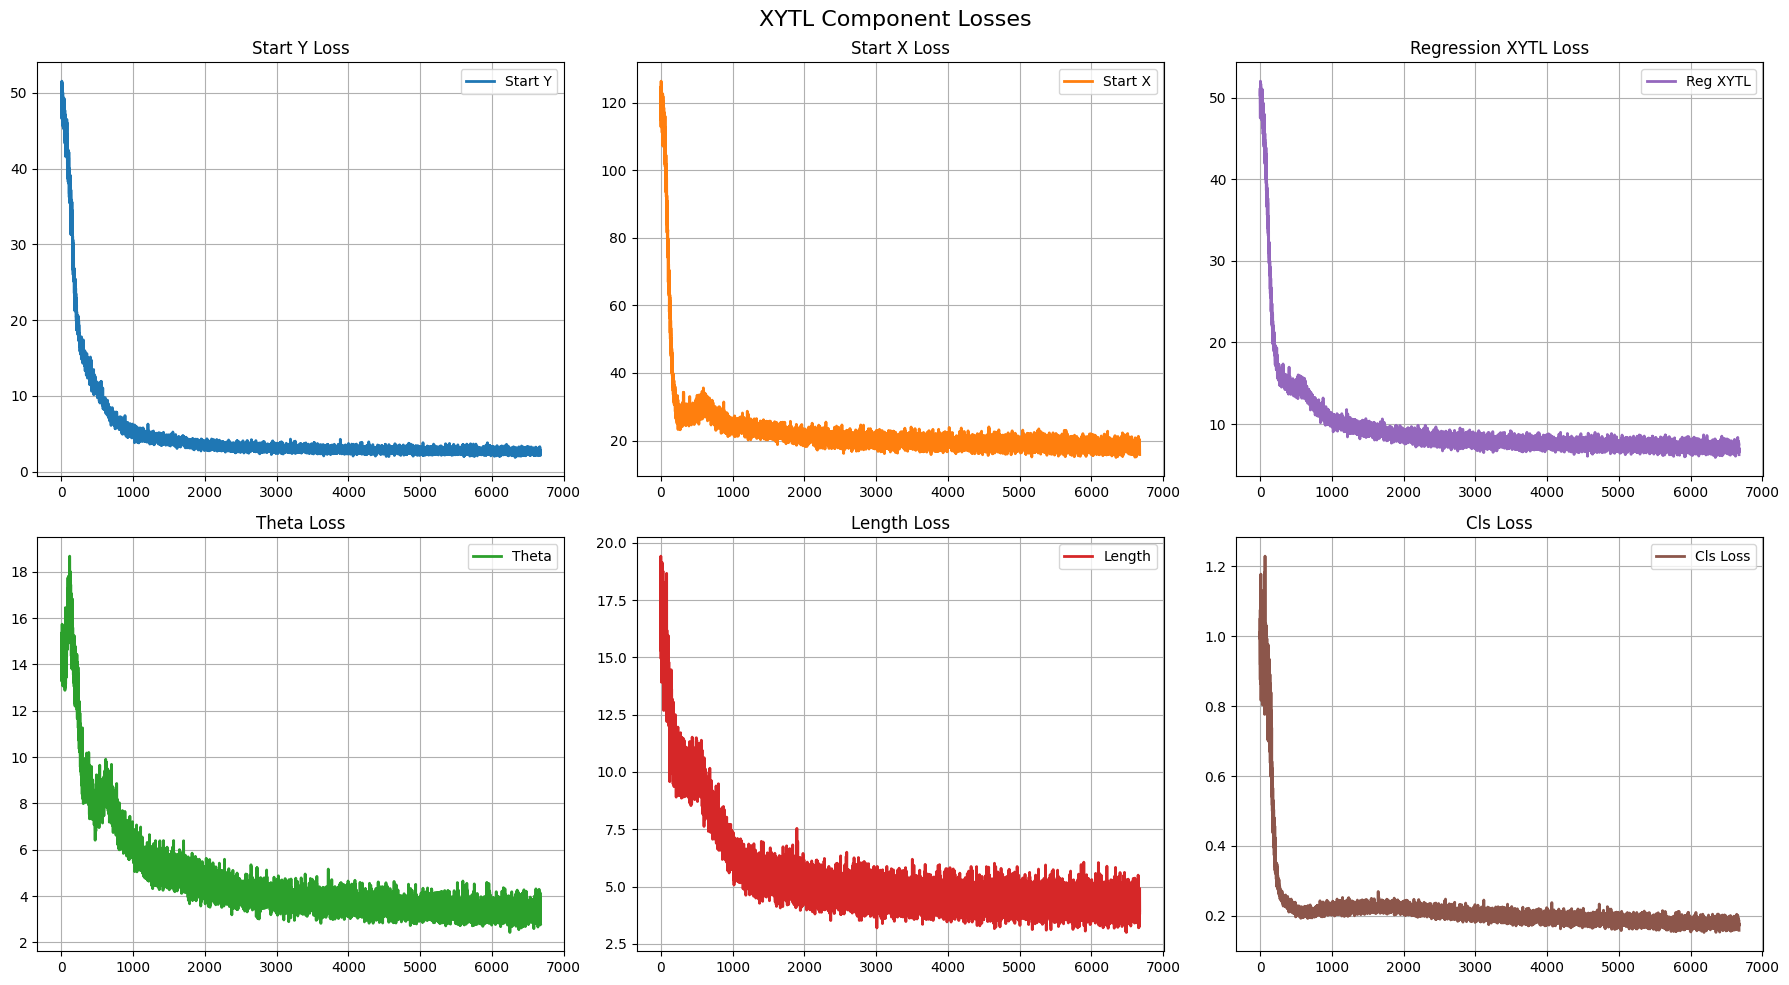

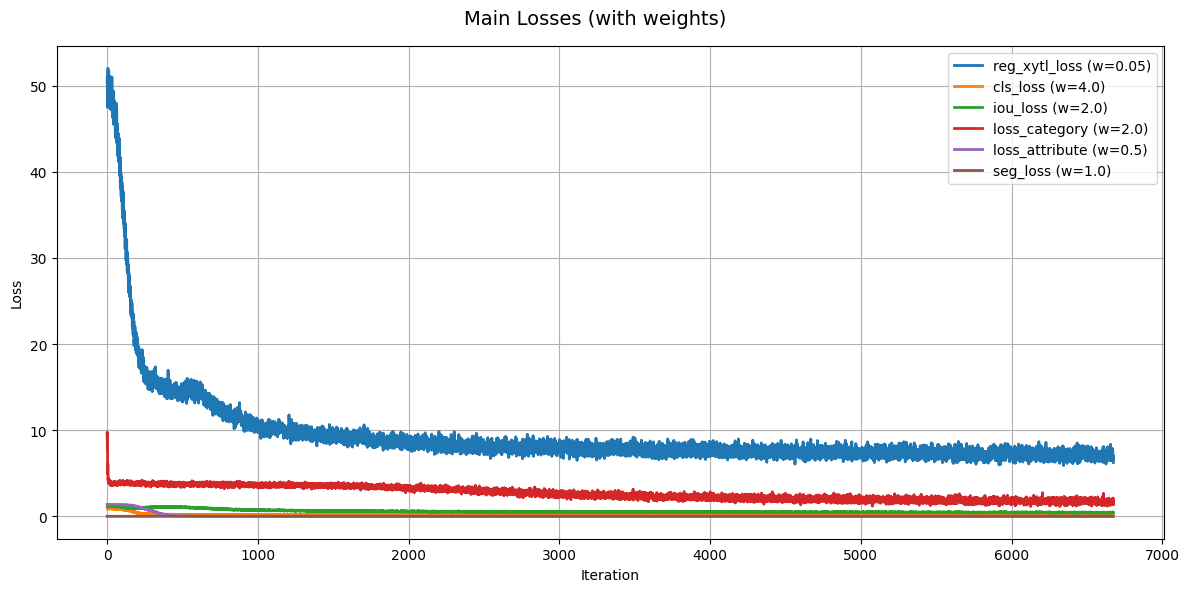

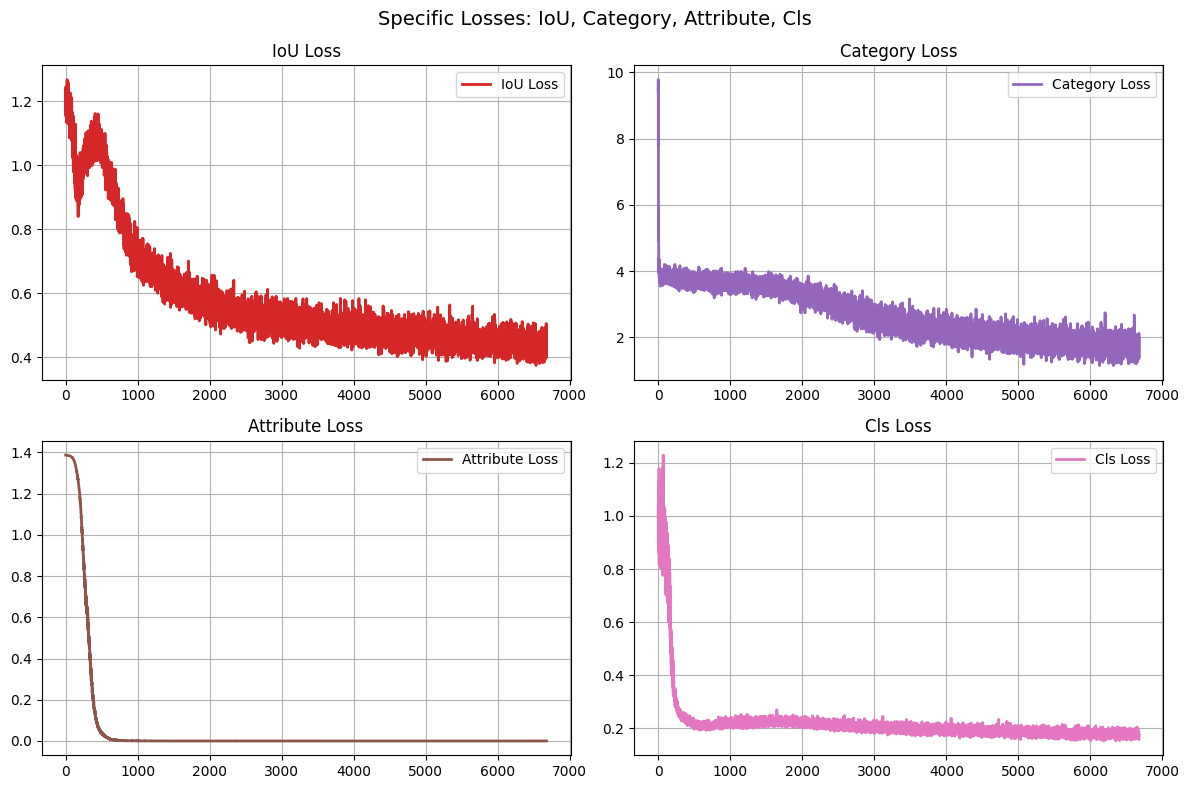

✅ 图表更新完成，下次更新在迭代 6680 或之后


In [15]:
# ========== HTML 按钮区域（第 3 个 cell，索引 2）==========
from IPython.display import HTML, display

# 按钮点击执行第 2 个 cell（索引 1）
display(
    HTML(
        """
<div style="margin: 20px 0; padding: 15px; background: #f8f9fa; border-radius: 8px; border: 1px solid #dee2e6;">
    <h4 style="margin-top: 0; color: #495057;">🎮 损失图表控制面板</h4>
    <button onclick="IPython.notebook.execute_cell(1)" 
            style="padding: 12px 24px; font-size: 16px; background: #007bff; color: white; border: none; border-radius: 6px; cursor: pointer; margin-right: 10px;">
        🔄 刷新图表
    </button>
    <span id="status" style="margin-left: 20px; color: #6c757d; font-style: italic;">准备就绪</span>
</div>
<script>
// 添加点击反馈
document.querySelector('button').onclick = function() {
    document.getElementById('status').textContent = '刷新中... ' + new Date().toLocaleTimeString();
    setTimeout(function() {
        document.getElementById('status').textContent = '更新完成 ' + new Date().toLocaleTimeString();
    }, 2000);
};
</script>
"""
    )
)

# 初始加载一次图表
plot_all_losses()